In this notebook, we're going to talk about different statistical methods for summarizing time-series data. We will cover a variety of Python libraries: some that we've already discussed (`numpy`, `pandas`) and then [`scipy`](https://scipy.org/) — a scientific computing library with many tools for digital signal processing.


# Important: Run this code cell each time you start a new session!

In [4]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install scipy
!pip install os
!pip install mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import os
import mne

ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


In [5]:
!wget -Ncnp https://physionet.org/files/chbmit/1.0.0/chb01/chb01_03.edf

--2024-06-13 19:02:00--  https://physionet.org/files/chbmit/1.0.0/chb01/chb01_03.edf
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘chb01_03.edf’ not modified on server. Omitting download.



In [6]:
# Keep track of useful information for the dataset
sampling_rate_hz = 256
eeg_col = 'FP1-F7'

# Read in the data and create a time column
edf = mne.io.read_raw_edf('chb01_03.edf')
df = pd.DataFrame(edf.get_data().T, columns=edf.ch_names)
df['Time'] = np.arange(0, df.shape[0])* (1/sampling_rate_hz)

# Rename and keep useful columns
keep_cols = ['Time', eeg_col]
df = df[keep_cols]
df.rename(columns={eeg_col: 'EEG'}, inplace=True)

# Split off useful chunks of the recording according to annotations
df = df[(df['Time']>=10) & (df['Time']<=15)]
df['Time'] = df['Time'] - df['Time'].min()
df.to_csv('eeg.csv',index=False)

Extracting EDF parameters from /content/chb01_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-6-c80073cae4c3>:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  edf = mne.io.read_raw_edf('chb01_03.edf')


# Statistical Measures

For this notebook, we are going to look at a brief segment of EEG data recorded from a pediatric subject:

In [7]:
df = pd.read_csv('eeg.csv')
df.head()

,Time,EEG
0,0.000000,0.000060
1,0.003906,0.000068
2,0.007812,0.000074
3,0.011719,0.000080
4,0.015625,0.000081


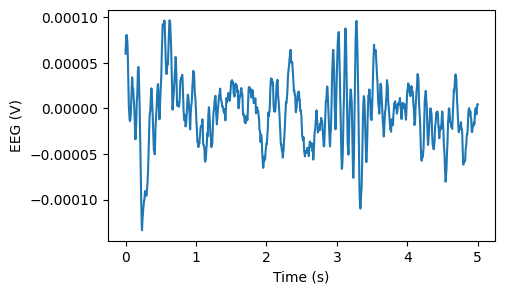

In [8]:
plt.figure(figsize=(5,3))
plt.plot(df['Time'], df['EEG'])
plt.xlabel('Time (s)')
plt.ylabel('EEG (V)')
plt.show()

In [9]:
time = df['Time'].values
eeg = df['EEG'].values

Here are some common statistical features you might encounter:

| Statistic | &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; Equation &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;| Purpose |
|:--------------:|:-----------:|:-------:|
| Minimum | $\displaystyle x_{min} = \min(x_i)$ | Smallest value of the signal |
| Maximum | $\displaystyle x_{max} = \max(x_i)$ | Largest value of the signal |
| Mean | $\displaystyle \mu = \frac{1}{n}\sum_{i=1}^{n} x_i$ | Average value of the signal |
| Standard deviation | $\displaystyle \sigma = \left[ \frac{1}{n-1}\sum_{i=1}^{n} (x_i-\mu)^2 \right]^{1/2}$  | Signal variance (usually normally distributed) |
| Root mean square | $\displaystyle x_{RMS} = \left[ \frac{1}{n}\sum_{i=1}^{n} x_i^2 \right]^{1/2}$ | Signal variance |
| Skewness | $\displaystyle x_{skew} = \frac{\sum_{i=1}^{n} (x_i-\mu)^3}{(n-1)\sigma^3} $ | Degree of asymmetry |
| Kurtosis | $\displaystyle x_{kurt} = \frac{\sum_{i=1}^{n} (x_i-\mu)^4}{(n-1)\sigma^4}$ | Degree of peakedness or flatness |

Let's manually write out the calculation for standard deviation to remind ourselves of how mathematical notation maps to Python:

In [10]:
def calc_stdev(x):
    n = len(x)
    mean_x = np.mean(x)
    sum = np.sum((x - mean_x)**2)
    return np.sqrt((1/(n-1))*sum)

In [11]:
print(f"Standard deviation: {calc_stdev(eeg)} V")

Standard deviation: 3.589904828026444e-05 V


While calculating the minimum and maximum is a very common approach to identifying the range of values in a time series, these measures are susceptible to extreme outliers. For example, imagine that we are monitoring a patient's daily step count. If they typically take 5,000 $\pm$ 500 steps a day but go on a hike on the weekend that took 15,000 steps, we may not want to count that hike when we are identifying the most steps that patient typically takes.

In situations when we want to be wary of outliers while still characterizing the highs and lows of a time series, we can do one of two things:
1. We can calculate the extremes of our data after throwing away outliers that fail a hand-crafted criterion
2. We can can calculate a ***percentile***, which  indicates the percentage of data points that fall below a specific value in a data set.

This function illustrates how we can calculate a percentile manually:

In [12]:
def calc_percentile(x, percent):
    x_sorted = x.copy()
    x_sorted.sort()
    percentile_idx = int((len(x)-1) * percent / 100)
    return x_sorted[percentile_idx]

In [13]:
print(f"0th percentile (min): {calc_percentile(eeg, 0)} V")
print(f"25th percentile: {calc_percentile(eeg, 25)} V")
print(f"50th percentile (median): {calc_percentile(eeg, 50)} V")
print(f"75th percentile: {calc_percentile(eeg, 75)} V")
print(f"100th percentile (max): {calc_percentile(eeg, 100)} V")

0th percentile (min): -0.000133431013431 V
25th percentile: -2.363858363858364e-05 V
50th percentile (median): -2.5396825396825403e-06 V
75th percentile: 1.6605616605616603e-05 V
100th percentile (max): 9.67032967032967e-05 V


# Data Processing with Libraries

Fortunately, many data science libraries — `numpy`, `pandas`, and `scipy` — provide functions and methods for most of the standard statistical measures you will likely need in order to summarize useful information about your time-series data.

In [14]:
print(f"Standard deviation: {np.std(eeg):0.2f} V")
print(f"0th percentile: {np.percentile(eeg, 0):0.2f} V")
print(f"50th percentile: {np.percentile(eeg, 50):0.2f} V")

Standard deviation: 0.00 V
0th percentile: -0.00 V
50th percentile: -0.00 V


Remember the code we wrote to make a peak detector earlier? `scipy` provides a much fancier one with all sorts of parameters we can configure, such as the required height of a valid peak or the minimum spacing between successive peaks.

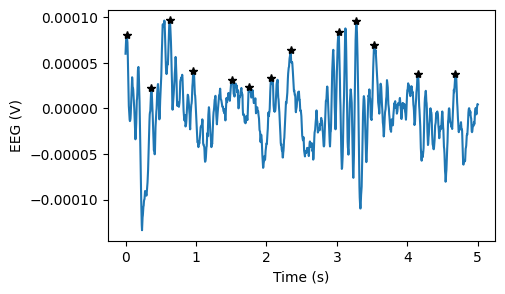

In [15]:
from scipy.signal import find_peaks
min_height = 0.00002 #@param {type:"slider", min:1e-5, max:5e-5, step:1e-5}
min_distance_samples = 50 #@param {type:"slider", min:25, max:100, step:25}

peaks, _ = find_peaks(eeg, height=min_height, distance=min_distance_samples)
plt.figure(figsize=(5, 3))
plt.plot(time, eeg)
plt.plot(time[peaks], eeg[peaks], "k*")
plt.xlabel('Time (s)')
plt.ylabel('EEG (V)')
plt.show()

These are just some examples of the thousands of tools libraries provide to help you manipulate time-series data. We will touch on some more specific examples as we begin to work on other kinds of data (e.g., images, audio), but you should now have the conceptual tools you need to use about 50% of what's out there!

# Putting Everything Together

Let's use everything we've learned to extract meaningful information about our signal. In this example, we want to identify periods of low- and high-activity levels in our EEG signal.

For the sake of simplicity, we are going to use a 0.5-second window with 0% overlap in order to split our signal into distinct chunks. For each window, we will compute the standard deviation to determine how much activity is happening in that part of the signal. We will apply a hand-selected threshold see if that part of the signal has high or low variance, and we will label that chunk accordingly. The pseudocode for this algorithm is as follows:

```
initialize our window
add a DataFrame column to store the activity level
assume that activity level is LOW for all samples

while the window had not reached the end of the signal:
    grab the data within the window
    compute the standard deviation in the window
    if it is above a threshold
        set the activity level for that data to HIGH
    move the window
```

And this is one way we can implement this algorithm:

In [16]:
def classify_activity(df, width, threshold):
    """
    df: a DataFrame containing EEG values over time
    width: the width of the windows measured in seconds
    threshold: the minimum threshold for high activity level
    """
    # Initialize the start and end of the window
    start_time = 0
    end_time = width

    # Initialize the column for storing activity level
    df['IsActivityHigh'] = False

    # Stop generating windows it would go past the end of the signal
    signal_duration = df['Time'].iloc[-1]
    while end_time < signal_duration:
        # Grab the current window by filtering indexes according to time
        window_idxs = (df['Time'] >= start_time) & (df['Time'] <= end_time)
        x_window = df['Time'][window_idxs]
        y_window = df['EEG'][window_idxs]

        # Calculate the activity level
        window_activity_level = y_window.std()

        # Update the activity level if it is high
        if window_activity_level > threshold:
            df.loc[window_idxs, 'IsActivityHigh'] = True

        # Move the window over by a stride
        start_time += width
        end_time += width

    # Show the activity level using transparency
    plt.figure(figsize=(5,3))
    plt.plot(df['Time'], df['EEG'])
    for idx in range(1, df.shape[0]):
        if df['IsActivityHigh'].iloc[idx]:
            plt.axvspan(df['Time'].iloc[idx-1], df['Time'].iloc[idx],
                        color='r', alpha=0.5, lw=0)
        else:
            plt.axvspan(df['Time'].iloc[idx-1], df['Time'].iloc[idx],
                        color='g', alpha=0.5, lw=0)
    plt.xlabel('Time (s)')
    plt.ylabel('EEG (V)')
    plt.title('Activity Level (green = low, red = high)')
    plt.show()

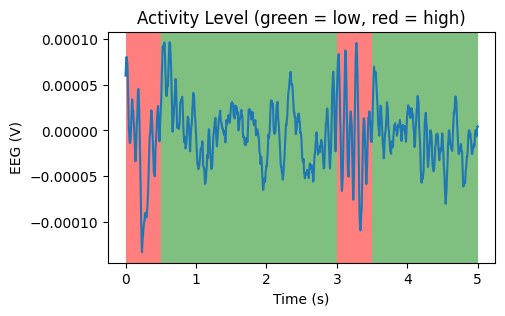

In [17]:
window_width = 0.5 #@param {type:"slider", min:0.5, max:1, step:0.25}
activity_threshold = 0.00005 #@param {type:"slider", min:1e-5, max:5e-5, step:1e-5}
classify_activity(df, window_width, activity_threshold)